In [25]:
import matplotlib.pyplot as plt 
import metapack as mp
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline

In [2]:
pkg = mp.open_package('http://library.metatab.org/ceden.waterboards.ca.gov-beachwatch-sandiego-2.zip')

pkg

df = pkg.resource('beachwatch-sd').read_csv(parse_dates=True)

# It looks like the prefix of the station code groups stations, maybe into watersheds. 
df['stationgroup'] = df.stationcode.str[:2]

df = df[['stationcode','sampledate','methodname','unit','analyte','result']]


In [3]:
# Group stats

dfc_gs = df[['stationcode','sampledate','methodname','analyte','unit', 'result']]\
         .groupby(['stationcode','methodname','analyte','unit']).agg({'result':['count','std','mean','median']})
dfc_gs.columns = ['result_count', 'group_std', 'group_mean', 'group_median']
#dfm.reset_index(inplace=True)
dfc_gs.head()

result_count    group_std  \
stationcode methodname  analyte         unit                                    
EH-010      Colilert-18 Coliform, Total MPN/100 mL            16  2754.504235   
                        E. coli         MPN/100 mL            16   414.620791   
            Enterolert  Enterococcus    MPN/100 mL           389   426.067900   
                                        cfu/100mL              9   681.020191   
            MTF         Coliform, Fecal MPN/100 mL           213  1647.469843   

                                                     group_mean  group_median  
stationcode methodname  analyte         unit                                   
EH-010      Colilert-18 Coliform, Total MPN/100 mL  2069.125000         524.0  
                        E. coli         MPN/100 mL   190.500000          20.0  
            Enterolert  Enterococcus    MPN/100 mL   151.406170          10.0  
                                        cfu/100mL    320.333333          10.0  
            MTF         Coliform, Fecal MPN/100 mL   376.478873          20.0

In [4]:
_1 = df.set_index(['stationcode','methodname','analyte','unit']).join(dfc_gs).reset_index()

# Mark the records that are in excess of the median and mean,
_1['gt_median'] = _1.result > _1.group_median
_1['gt_mean']   = _1.result > _1.group_mean

# However, we still have an issue with there being multiple measurements per day/analyte/method/station. 
# The gt_mean and gt_median are now linked to the mean and median for the day/analyte/method/station, so let's just
# consider that normalization enough and average the flags. Since they are binary, they will  convert to 0/1

#_2 = _1.reset_index().set_index('sampledate').groupby(['stationcode','methodname','analyte','unit']).resample('1d').mean().reset_index()
#dfc = _2.copy()
dfc = _1

dfc.loc[dfc['gt_median'].notnull(), 'gt_median'] = dfc['gt_median'] >= .5
dfc.loc[dfc['gt_mean'].notnull(), 'gt_mean'] = dfc['gt_mean'] >= .5

dfc.head()


,stationcode,methodname,analyte,unit,sampledate,result,result_count,group_std,group_mean,group_median,gt_median,gt_mean
0,EH-010,Colilert-18,"Coliform, Total",MPN/100 mL,2006-04-29,6488.0,16,2754.504235,2069.125,524.0,True,True
1,EH-010,Colilert-18,"Coliform, Total",MPN/100 mL,2006-05-08,10.0,16,2754.504235,2069.125,524.0,False,False
2,EH-010,Colilert-18,"Coliform, Total",MPN/100 mL,2006-05-15,771.0,16,2754.504235,2069.125,524.0,True,False
3,EH-010,Colilert-18,"Coliform, Total",MPN/100 mL,2006-07-17,4884.0,16,2754.504235,2069.125,524.0,True,True
4,EH-010,Colilert-18,"Coliform, Total",MPN/100 mL,2006-08-27,41.0,16,2754.504235,2069.125,524.0,False,False


In [5]:

dfc.gt_median.value_counts(dropna=False)

False    136116
True      66141
Name: gt_median, dtype: int64

In [6]:
# Proportion of gt_mean and mt_median that are different. 
len(dfc[ dfc.gt_median.notnull() & dfc.gt_mean.notnull() &  (dfc.gt_median != dfc.gt_mean)])  / len(dfc)

0.2110631523260011

In [7]:
_ = dfc[dfc.gt_median.notnull()]
len(_[_.gt_median]) / len(_)

0.3270146397899702

In [8]:
_ = dfc[dfc.gt_mean.notnull()]
len(_[_.gt_mean>= 0.5]) / len(_)

0.11829504046831507

In [9]:
dfc.head()

,stationcode,methodname,analyte,unit,sampledate,result,result_count,group_std,group_mean,group_median,gt_median,gt_mean
0,EH-010,Colilert-18,"Coliform, Total",MPN/100 mL,2006-04-29,6488.0,16,2754.504235,2069.125,524.0,True,True
1,EH-010,Colilert-18,"Coliform, Total",MPN/100 mL,2006-05-08,10.0,16,2754.504235,2069.125,524.0,False,False
2,EH-010,Colilert-18,"Coliform, Total",MPN/100 mL,2006-05-15,771.0,16,2754.504235,2069.125,524.0,True,False
3,EH-010,Colilert-18,"Coliform, Total",MPN/100 mL,2006-07-17,4884.0,16,2754.504235,2069.125,524.0,True,True
4,EH-010,Colilert-18,"Coliform, Total",MPN/100 mL,2006-08-27,41.0,16,2754.504235,2069.125,524.0,False,False


# Merge in environmental data

In [10]:
env_pkg =  mp.open_package('http://library.metatab.org/sandiegodata.org-water_quality-4.zip')

In [11]:
trr = env_pkg.resource('tides_river_rain').read_csv(parse_dates=True).set_index('date')
trr.head()

,discharge_rate,recent_total_discharge,recent_max_discharge,dailyprecip,recent_precip,wl_max,wl_min
date,,,,,,,
1988-01-01,22.0,22.0,22.0,NaN,NaN,NaN,NaN
1988-01-02,20.0,42.0,42.0,NaN,NaN,NaN,NaN
1988-01-03,18.0,60.0,60.0,NaN,NaN,NaN,NaN
1988-01-04,18.0,56.0,60.0,NaN,NaN,NaN,NaN
1988-01-05,21.0,57.0,60.0,NaN,NaN,NaN,NaN


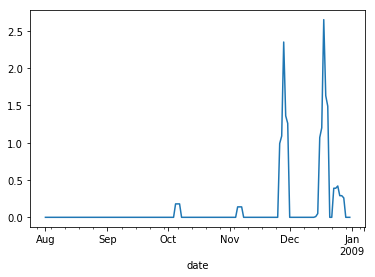

In [12]:
trr.loc['2007':'2008'].recent_precip.plot()

In [13]:
dfc_env = dfc.set_index('sampledate').join(trr)
dfc_env['high_flow'] =  (dfc_env.recent_total_discharge > dfc_env.recent_total_discharge.median()).astype(int)


dfc_env.head()

,stationcode,methodname,analyte,unit,result,result_count,group_std,group_mean,group_median,gt_median,gt_mean,discharge_rate,recent_total_discharge,recent_max_discharge,dailyprecip,recent_precip,wl_max,wl_min,high_flow
1998-07-21,SE-010,MTF,"Coliform, Fecal",MPN/100 mL,4.0,527,225.561709,51.220114,4.0,False,False,8.8,27.0,27.4,NaN,NaN,NaN,NaN,1
1998-07-21,SE-010,MTF,"Coliform, Total",MPN/100 mL,4.0,530,309.086717,84.126415,8.0,False,False,8.8,27.0,27.4,NaN,NaN,NaN,NaN,1
1998-07-21,SE-010,MTF,Enterococcus,MPN/100 mL,2.0,488,148.631518,24.676230,2.0,False,False,8.8,27.0,27.4,NaN,NaN,NaN,NaN,1
1998-07-21,SE-020,MTF,"Coliform, Fecal",MPN/100 mL,23.0,477,128.262880,20.035639,2.0,True,True,8.8,27.0,27.4,NaN,NaN,NaN,NaN,1
1998-07-21,SE-020,MTF,"Coliform, Total",MPN/100 mL,23.0,477,263.711243,35.614256,4.0,True,False,8.8,27.0,27.4,NaN,NaN,NaN,NaN,1


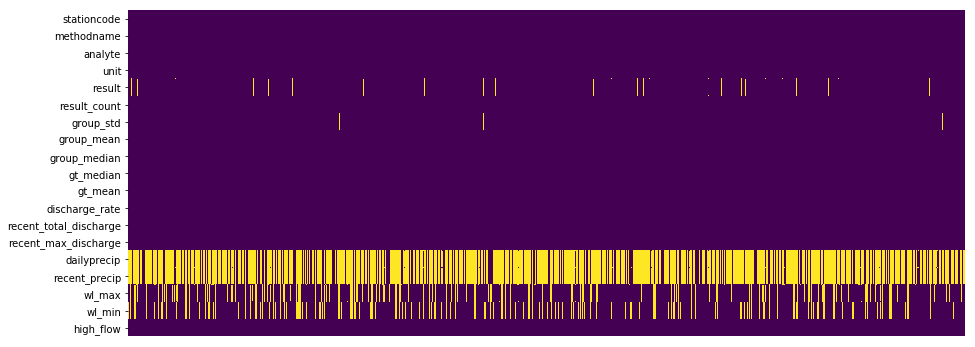

In [14]:
fig, ax = plt.subplots(figsize=(15,.5*len(dfc.columns)))
sns.heatmap(dfc_env.sample(10000).isnull().T,cbar=False,xticklabels=False,cmap = 'viridis', ax=ax );

In [15]:
sum(dfc_env.recent_precip > 0.0)

8440

In [16]:
dfc_env.groupby('gt_mean').mean().discharge_rate

gt_mean
False    13.473382
True     83.617916
Name: discharge_rate, dtype: float64

In [17]:
dfc_env.groupby('gt_mean').discharge_rate.agg(['mean','std','median'])

,mean,std,median
gt_mean,,,
False,13.473382,48.410475,3.42
True,83.617916,295.527887,7.05


In [18]:
dfc_env.groupby('gt_median').mean().discharge_rate

gt_median
False    10.273435
True     45.433016
Name: discharge_rate, dtype: float64

In [19]:
dfc_env.groupby('gt_mean').mean().recent_precip

gt_mean
False    0.034588
True     0.207037
Name: recent_precip, dtype: float64

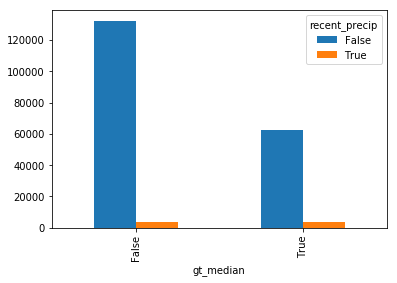

In [20]:
pd.crosstab(dfc_env.gt_median, dfc_env.recent_precip > 0.01 ).plot(kind='bar')

In [21]:
def logit(y,X):
    import statsmodels.api as sm

    X_ = pd.DataFrame()
   
    X_['X'] = X
    X_['const'] = 1

    logit_model=sm.Logit(y,X_)
    result=logit_model.fit()
    print(result.summary())

    # Odds ratio and conf interval
    params = result.params
    conf = result.conf_int()
    conf['OR'] = params
    conf.columns = ['2.5%', '97.5%', 'OR']
    print(np.exp(conf))
    
logit(
    y = dfc_env.gt_median.astype(int), 
    X = (dfc_env.recent_precip.fillna(0) > 0).astype(int)
)

Optimization terminated successfully.
         Current function value: 0.630014
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:              gt_median   No. Observations:               202257
Model:                          Logit   Df Residuals:                   202255
Method:                           MLE   Df Model:                            1
Date:                Mon, 06 Aug 2018   Pseudo R-squ.:                0.003213
Time:                        16:25:27   Log-Likelihood:            -1.2742e+05
converged:                       True   LL-Null:                   -1.2784e+05
                                        LLR p-value:                1.175e-180
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
X              0.6481      0.022     29.015      0.000       0.604       0.692
const         -0.7510      0.

That's an oad ratio of nearly 1:2, so days with non-zero recent precipitation are about twice as likely to have a bacteria county above the median

In [22]:
logit(
    y = dfc_env.gt_median.astype(int), 
    X = dfc_env.recent_precip.fillna(0)
)


Optimization terminated successfully.
         Current function value: 0.628335
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              gt_median   No. Observations:               202257
Model:                          Logit   Df Residuals:                   202255
Method:                           MLE   Df Model:                            1
Date:                Mon, 06 Aug 2018   Pseudo R-squ.:                0.005869
Time:                        16:25:28   Log-Likelihood:            -1.2709e+05
converged:                       True   LL-Null:                   -1.2784e+05
                                        LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
X              1.7655      0.054     32.969      0.000       1.661       1.870
const         -0.7462      0.

I think this means that a 1 unit ( 1 inch ) increase in the recent precipitation increases the odds of above median bacteria counts by a factor of 6. 

In [23]:
logit(
    y = dfc_env.gt_median.astype(int), 
    X = dfc_env.recent_precip.fillna(0)
)

Optimization terminated successfully.
         Current function value: 0.628335
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              gt_median   No. Observations:               202257
Model:                          Logit   Df Residuals:                   202255
Method:                           MLE   Df Model:                            1
Date:                Mon, 06 Aug 2018   Pseudo R-squ.:                0.005869
Time:                        16:25:30   Log-Likelihood:            -1.2709e+05
converged:                       True   LL-Null:                   -1.2784e+05
                                        LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
X              1.7655      0.054     32.969      0.000       1.661       1.870
const         -0.7462      0.

In [24]:
_1 = pd.DataFrame()
_1['y'] = dfc_env.gt_median.astype(int)
_1['X'] = dfc_env.recent_precip.apply(lambda x: 1 if x > 1.5 else 0 if x < .5 else np.nan)
_2 = _1.dropna()

logit(
    y = _2['y'],
    X = _2['X']
)



Optimization terminated successfully.
         Current function value: 0.579082
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                52202
Model:                          Logit   Df Residuals:                    52200
Method:                           MLE   Df Model:                            1
Date:                Mon, 06 Aug 2018   Pseudo R-squ.:                0.009144
Time:                        16:25:31   Log-Likelihood:                -30229.
converged:                       True   LL-Null:                       -30508.
                                        LLR p-value:                2.379e-123
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
X              3.5833      0.232     15.434      0.000       3.128       4.038
const         -1.0069      0.

I think this means that a greater than median reading is 36 times more likely with a recent rainfall of 1.5 inches or greater than with .5 inch or less. 